# Graph Embeddings - CareerVillage Dataset

In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
from sklearn import svm
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from collections import Counter
from node2vec import Node2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
files = os.listdir("/home/mona/input")
#files = os.listdir("/Users/Paula/GoogleDrive/MIRI/Q4/SDM/Project/data-careervillage")

In [5]:
data_parts = {}
for file_name in files:
    file_id = file_name.split(".")[0]
    data_parts[file_id] = pd.read_csv("/home/mona/input" +'/'+ file_name)
    # data_parts[file_id] = pd.read_csv("/Users/Paula/GoogleDrive/MIRI/Q4/SDM/Project/data-careervillage" +'/'+ file_name)
    print(file_id)
    print(data_parts[file_id].shape)

question_scores
(23928, 2)
school_memberships
(5638, 2)
answer_scores
(51138, 2)
tag_users
(136663, 2)
tags
(16269, 2)
group_memberships
(1038, 2)
comments
(14966, 5)
emails
(1850101, 4)
questions
(23931, 5)
answers
(51123, 5)
tag_questions
(76553, 2)
matches
(4316275, 2)
professionals
(28152, 5)
groups
(49, 2)
students
(30971, 3)


In [6]:
def add_nodes(G, df, col, type_name):
    """Add entities to G from the 'col' column of the 'df' DataFrame. The new nodes are annotated with 'type_name' label."""
    nodes = list(df[~df[col].isnull()][col].unique())
    G.add_nodes_from([(n,dict(type=type_name)) for n in nodes])
    print("Nodes (%s,%s) were added" % (col, type_name))
    
def add_links(G, df, col1, col2, type_name):
    """Add links to G from the 'df' DataFrame. The new edges are annotated with 'type_name' label."""
    df_tmp = df[(~df[col1].isnull()) & (~df[col2].isnull())]
    links = list(zip(df_tmp[col1],df_tmp[col2]))
    G.add_edges_from([(src, trg, dict(type=type_name)) for src, trg in links])
    print("Edges (%s->%s,%s) were added" % (col1, col2, type_name))

In [7]:
G = nx.DiGraph()

# Add nodes and edges

In [8]:
add_nodes(G, data_parts["answers"], "answers_id", "answer")
add_nodes(G, data_parts["comments"], "comments_id", "comment")
add_nodes(G, data_parts["groups"], "groups_id", "group")
add_nodes(G, data_parts["groups"], "groups_group_type", "group_type")
add_nodes(G, data_parts["professionals"], "professionals_id", "professional")
add_nodes(G, data_parts["professionals"], "professionals_industry", "industry")
add_nodes(G, data_parts["questions"], "questions_id", "question")
add_nodes(G, data_parts["school_memberships"], "school_memberships_school_id", "school")
add_nodes(G, data_parts["students"], "students_id", "student")
add_nodes(G, data_parts["tags"], "tags_tag_id", "tag")

Nodes (answers_id,answer) were added
Nodes (comments_id,comment) were added
Nodes (groups_id,group) were added
Nodes (groups_group_type,group_type) were added
Nodes (professionals_id,professional) were added
Nodes (professionals_industry,industry) were added
Nodes (questions_id,question) were added
Nodes (school_memberships_school_id,school) were added
Nodes (students_id,student) were added
Nodes (tags_tag_id,tag) were added


In [9]:
add_links(G, data_parts["answers"], "answers_id", "answers_question_id", "question")
add_links(G, data_parts["answers"], "answers_id", "answers_author_id", "author")
add_links(G, data_parts["comments"], "comments_id", "comments_parent_content_id", "parent_content")
add_links(G, data_parts["comments"], "comments_id", "comments_author_id", "author")
add_links(G, data_parts["group_memberships"], "group_memberships_user_id", "group_memberships_group_id", "member")
add_links(G, data_parts["groups"], "groups_id", "groups_group_type", "type")
add_links(G, data_parts["professionals"], "professionals_id", "professionals_industry", "type")
add_links(G, data_parts["questions"], "questions_id", "questions_author_id", "author")
add_links(G, data_parts["school_memberships"], "school_memberships_user_id", "school_memberships_school_id", "member")
add_links(G, data_parts["tag_questions"], "tag_questions_question_id", "tag_questions_tag_id", "tag")
add_links(G, data_parts["tag_users"], "tag_users_user_id", "tag_users_tag_id", "follow")

Edges (answers_id->answers_question_id,question) were added
Edges (answers_id->answers_author_id,author) were added
Edges (comments_id->comments_parent_content_id,parent_content) were added
Edges (comments_id->comments_author_id,author) were added
Edges (group_memberships_user_id->group_memberships_group_id,member) were added
Edges (groups_id->groups_group_type,type) were added
Edges (professionals_id->professionals_industry,type) were added
Edges (questions_id->questions_author_id,author) were added
Edges (school_memberships_user_id->school_memberships_school_id,member) were added
Edges (tag_questions_question_id->tag_questions_tag_id,tag) were added
Edges (tag_users_user_id->tag_users_tag_id,follow) were added


# Preprocess the data

In [10]:
students = data_parts["students"]
profs = data_parts["professionals"]
students = students[~students["students_location"].isnull()]
profs = profs[~profs["professionals_location"].isnull()]

In [11]:
locs1 = list(students["students_location"])
locs2 = list(profs["professionals_location"])
locs = []
for loc in locs1+locs2: 
    locs.append(loc.lower())
locs_unique = list(set(locs))

In [12]:
new_edges = []
new_nodes = []

for loc in locs_unique:
    loc_hierarchy = loc.split(", ")
    loc_nodes = [] # due to city name duplicates in the world
    k = len(loc_hierarchy)
    
    for i in range(k):
        loc_nodes.append('_'.join(loc_hierarchy[i:]))
        
    new_nodes += loc_nodes
    loc_links = [(loc_nodes[i],loc_nodes[i+1], dict(type="location"))  for i in range(k-1)]
    new_edges += loc_links
new_nodes = list(set(new_nodes))
new_nodes = [(n, dict(type="location")) for n in new_nodes] 

In [13]:
G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)
print(len(new_edges), len(new_nodes))

7253 7160


In [14]:
students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))

/tmp/ipykernel_762/1738426549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students["students_location"] = students["students_location"].apply(lambda x: "_".join(x.lower().split(", ")))
/tmp/ipykernel_762/1738426549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profs["professionals_location"] = profs["professionals_location"].apply(lambda x: "_".join(x.lower().split(", ")))


In [15]:
add_links(G, students, "students_id", "students_location", "location")
add_links(G, profs, "professionals_id", "professionals_location", "location")

Edges (students_id->students_location,location) were added
Edges (professionals_id->professionals_location,location) were added


In [16]:
def encode_graph(G):
    """Encode the nodes of the network into integers"""
    nodes = [(n,d.get("type",None)) for n, d in G.nodes(data=True)]
    nodes_df = pd.DataFrame(nodes, columns=["id","type"]).reset_index()
    node2idx = dict(zip(nodes_df["id"],nodes_df["index"]))
    edges = [(node2idx[src], node2idx[trg], d.get("type",None)) for src, trg, d in G.edges(data=True)]
    edges_df = pd.DataFrame(edges, columns=["src","trg","type"])
    return nodes_df, edges_df

In [17]:
print(G.number_of_nodes(), G.number_of_edges())
G.remove_nodes_from(list(nx.isolates(G)))
print(G.number_of_nodes(), G.number_of_edges())

177890 461369
174181 461369


In [18]:
nodes_df, edges_df = encode_graph(G)
len(nodes_df), len(edges_df)

(174181, 461369)

# Node Information

In [19]:
print(nodes_df.head())
print(nodes_df["type"].value_counts())
nodes_df.to_csv("knowledge_graph_nodes.csv", index=False)

   index                                id    type
0      0  4e5f01128cae4f6d8fd697cec5dca60c  answer
1      1  ada720538c014e9b8a6dceed09385ee3  answer
2      2  eaa66ef919bc408ab5296237440e323f  answer
3      3  1a6b3749d391486c9e371fbd1e605014  answer
4      4  5229c514000446d582050f89ebd4e184  answer
answer          51123
student         29460
professional    27819
question        23931
comment         14966
tag             14404
location         7160
school           2706
industry         2470
group              49
group_type          7
Name: type, dtype: int64


# Edge Information

In [20]:
print(edges_df.head())
print(edges_df["type"].value_counts())
edges_df[["src","trg"]].to_csv("knowledge_graph_edges.csv", index=False, header=False, sep=" ")

   src    trg      type
0    0  96434  question
1    0  68352    author
2    1  96435  question
3    1  83417    author
4    2  96435  question
follow            135907
author             90020
tag                76553
location           60724
question           51123
type               25625
parent_content     14966
member              6451
Name: type, dtype: int64


# Deepwalk

In [21]:
edge_list = list(zip(edges_df["src"],edges_df["trg"]))
len(edge_list)

461369

In [22]:
KG = nx.DiGraph(edge_list)
KG.number_of_nodes(), KG.number_of_edges()

(174181, 461369)

In [23]:
from ge import DeepWalk

In [24]:
model_dw = DeepWalk(KG,walk_length=5,num_walks=10,workers=1)#init model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished


In [25]:
model_dw.train(embed_size=10, window_size=3,iter=3)# train model

Learning embedding vectors...
Learning embedding vectors done!


In [26]:
embedding_dw = model_dw.get_embeddings()

In [27]:
nodes_df_dw = nodes_df.copy()

In [28]:
nodes_df_dw["vector"]=nodes_df_dw.index.map(embedding_dw)

In [30]:
split_df_nodes_dw = pd.DataFrame(nodes_df_dw['vector'].tolist())

In [31]:
nodes_df_dw = pd.concat([split_df_nodes_dw , nodes_df_dw["type"], nodes_df_dw["index"]], axis=1)

In [106]:
selected_stu_prof= nodes_df_dw.loc[(nodes_df_dw["type"] == "student") | (nodes_df_dw["type"] == "professional")]

In [38]:
selected_stu_prof["type"] = selected_stu_prof["type"].astype(str)

/tmp/ipykernel_762/3779151144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_stu_prof["type"] = selected_stu_prof["type"].astype(str)


In [35]:
train_dw, test_dw = train_test_split(selected_stu_prof, test_size=0.2, random_state=42, shuffle=True)

In [36]:
print(train_dw.shape[0])
print(test_dw.shape[0])

45823
11456


In [45]:
clf = svm.SVC()
clf.fit(train_dw.iloc[:,0:10], train_dw.iloc[:,10])

SVC()

In [46]:
prediction_tag = clf.predict(test_dw.iloc[:,0:10]) 

In [49]:
Accuracy_Score = accuracy_score(test_dw.iloc[:,10], prediction_tag)
print(round(Accuracy_Score*100,2))

87.05


In [114]:
from sklearn.metrics import plot_confusion_matrix

/home/mona/.local/lib/python3.8/site-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


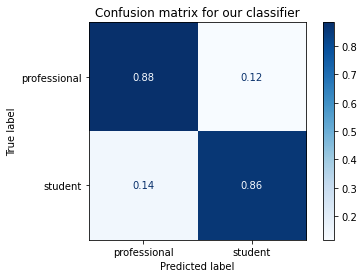

In [115]:
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, test_dw.iloc[:,0:10], test_dw.iloc[:,10],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

# Node2vec

In [90]:
from ge import Node2Vec

In [91]:
df_nodes_n2v = nodes_df.copy()

In [92]:
model_nv = Node2Vec(KG, walk_length=5, num_walks=10, workers=1, p=1, q=2, use_rejection_sampling=0)
model_nv.train(embed_size=128, window_size=3, iter=3)
embeddings_nv = model_nv.get_embeddings()

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s finished


Learning embedding vectors...
Learning embedding vectors done!


In [93]:
df_nodes_n2v["vector"]=df_nodes_n2v.index.map(embeddings_nv)

In [96]:
split_df_nodes_n2v = pd.DataFrame(df_nodes_n2v['vector'].tolist())

In [97]:
nodes_df_n2v = pd.concat([split_df_nodes_n2v , df_nodes_n2v["type"], df_nodes_n2v["index"]], axis=1)

In [99]:
selected_stu_prof_nv= nodes_df_n2v.loc[(nodes_df_n2v["type"] == "student") | (nodes_df_n2v["type"] == "professional")]
selected_stu_prof_nv.shape[0]

57279

In [100]:
train_nv, test_nv = train_test_split(selected_stu_prof_nv, test_size=0.2, random_state=42, shuffle=True)

In [103]:
clf_nv = svm.SVC()
clf_nv.fit(train_nv.iloc[:,0:128], train_nv.iloc[:,128])

SVC()

In [104]:
prediction_tag_nv = clf_nv.predict(test_nv.iloc[:,0:128]) 

In [105]:
Accuracy_Score_nv = accuracy_score(test_nv.iloc[:,128], prediction_tag_nv)
print(round(Accuracy_Score_nv*100,2))

74.56


# Dimension reduction - visualization

In [107]:
def plot_embeddings(embeddings,x,y):
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)



    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])

        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)

    plt.legend()

    plt.show()


/home/mona/.local/lib/python3.8/site-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mona/.local/lib/python3.8/site-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


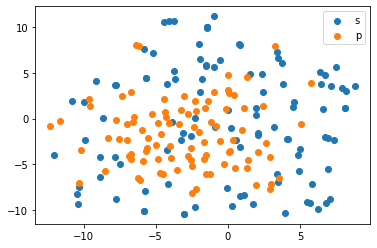

In [117]:
plot_embeddings(embedding_dw,list(train_dw.iloc[:,11])[0:3000],list(train_dw.iloc[:,10])[0:3000])